In [1]:
# !jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -N -kl -cursw 5 -cursc r -cellw 95% -T

# House pricing project

## Exploration Data Analysis

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from IPython.paths import get_ipython_dir
print(get_ipython_dir())

/home/pjtien/.ipython


In [4]:
import matplotlib, sklearn
print(f"matplotlib: {matplotlib.__version__}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"sklearn: {sklearn.__version__}")


matplotlib: 3.3.2
pandas: 1.1.4
numpy: 1.19.4
seaborn: 0.10.1
sklearn: 0.24.1


In [5]:
df = pd.read_csv("train.csv").rename(columns=lambda x: x.replace(".",""))
target = "TARGET(PRICE_IN_LACS)"


Column	| Description
------|------
POSTED_BY |	Category marking who has listed the property
UNDER_CONSTRUCTION |	Under Construction or Not
RERA	| Rera approved or Not
BHK_NO	| Number of Rooms
BHKORRK	| Type of property
SQUARE_FT | Total area of the house in square feet
READYTOMOVE	| Category marking Ready to move or Not
RESALE	| Category marking Resale or not
ADDRESS	| Address of the property
LONGITUDE |	Longitude of the property
LATITUDE  |	Latitude of the property


In [6]:
# derive sub_city and city from ADDRESS.
def derive_sub_city(x):
    c= x.split(",")
    if len(c) > 2:
        return pd.Series([",".join(c[:2]), c[-1]])
    return pd.Series([c[0], c[1]])
    
# df["city", "state"]  = df.apply(derive_sub_city, axis=1)
df[["SUB_CITY", "CITY"]]  = df["ADDRESS"].apply(lambda x: derive_sub_city(x))

In [7]:
print(df.shape)
df.head()

(29451, 14)


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),SUB_CITY,CITY
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,Ksfc Layout,Bangalore
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,Vishweshwara Nagar,Mysore
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,Jigani,Bangalore
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,Sector-1 Vaishali,Ghaziabad
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,New Town,Kolkata


In [8]:
print("There is no null value in the dataset. ")
display(df.info()) 
display(df.describe())

There is no null value in the dataset. 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO                 29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
 12  SUB_CITY               29451 non-null  object 
 13  CITY                   29451 non-null  object 
dtypes: float64(4),

None

,UNDER_CONSTRUCTION,RERA,BHK_NO,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


In [9]:
# data transformation.
# derive log transformation on target and binning it.
# derive UNIT_PRICE_PER_SQ
def log_fn(x):
    return np.log(x)
def inverse_fn(x):
    return np.exp(x)
df[f"{target}_log"] = df[target].apply(lambda x: log_fn(x))
df[f"{target}_log_bin"] = pd.qcut(df[f"{target}_log"], q=4, labels=[1,2,3,4])
df["UNIT_PRICE_PER_SQ"] = df["TARGET(PRICE_IN_LACS)"]/df["SQUARE_FT"]
df.eval("SQUARE_FT_PER_ROOM = SQUARE_FT / BHK_NO", inplace=True)

In [10]:
numerical_features = ['BHK_NO', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']
categorical_features = ['POSTED_BY',
                        'UNDER_CONSTRUCTION', 
                        'RERA', 
                        'BHK_OR_RK', 
                        'READY_TO_MOVE', 
                        'RESALE', 
                        # 'ADDRESS',
                        'SUB_CITY',
                        'CITY'
                       ]

### EAD: target analysis 

count    29451.000000
mean       142.898746
std        656.880713
min          0.250000
25%         38.000000
50%         62.000000
75%        100.000000
max      30000.000000
Name: TARGET(PRICE_IN_LACS), dtype: float64

TARGET(PRICE_IN_LACS) distribution


<AxesSubplot:>

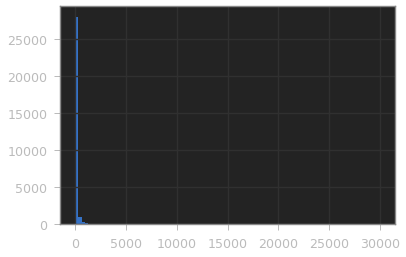

In [11]:
def show_number_of_std(dfx, name="max"):
    """ return number of std away from the mean
    dfx: DataFrame.
    name: str.
    """
    return abs(dfx.loc[name] - dfx.loc["mean"])/dfx.loc["std"]
    

target_summary_df = df[target].describe()
num_of_std_max = show_number_of_std(target_summary_df, "max")
num_of_std_min = show_number_of_std(target_summary_df, "min")
std_y = target_summary_df.loc["std"]
mean_y = target_summary_df.loc["mean"]
med_y = target_summary_df.loc["50%"]
display(target_summary_df)
print(f"{target} distribution")
display(df[target].hist(bins=100))

TARGET(PRICE_IN_LACS)_log distribution


<AxesSubplot:>

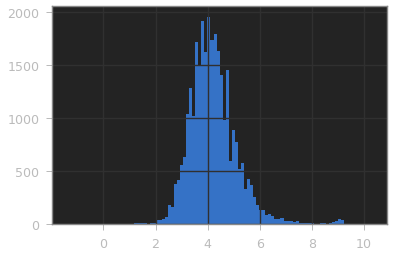

In [12]:
print(f"{target}_log distribution")
display(df[f"{target}_log"].hist(bins=100))

In [13]:
print("Right skew: heavy tail distribution in the target. "
      f"Price: mean = {mean_y}, median ={med_y}, std = {std_y}. "
      f"The number of max value has {num_of_std_max} away from the mean. "
      f"The number of min value has {num_of_std_min} away from the mean. "
      )

Right skew: heavy tail distribution in the target. Price: mean = 142.8987457132186, median =62.0, std = 656.8807127981115. The number of max value has 45.45285113807747 away from the mean. The number of min value has 0.21716080702929827 away from the mean. 


### EAD: categorical features

In [14]:
categorical_features

['POSTED_BY',
 'UNDER_CONSTRUCTION',
 'RERA',
 'BHK_OR_RK',
 'READY_TO_MOVE',
 'RESALE',
 'SUB_CITY',
 'CITY']

array([[<AxesSubplot:title={'center':'UNDER_CONSTRUCTION'}>,
        <AxesSubplot:title={'center':'RERA'}>],
       [<AxesSubplot:title={'center':'READY_TO_MOVE'}>,
        <AxesSubplot:title={'center':'RESALE'}>]], dtype=object)

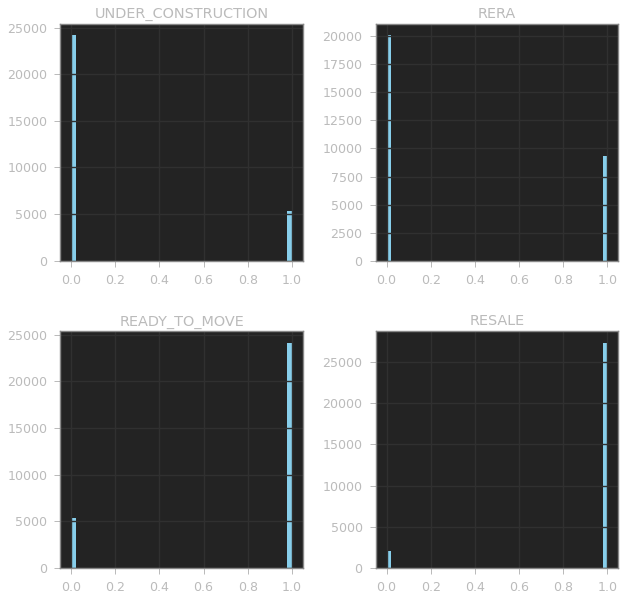

In [15]:
# Within categorical features, the population at each label of each categorical feature
# are un-balance.
df[categorical_features].hist(bins=50,figsize=(10,10), color="skyblue")

<AxesSubplot:>

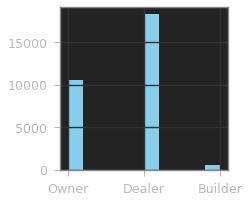

In [16]:
df["POSTED_BY"].hist(figsize=(3,3), color="skyblue")

<AxesSubplot:>

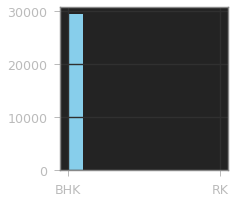

In [17]:
df["BHK_OR_RK"].hist(figsize=(3,3), color="skyblue")

In [18]:
# unbalanced case in categorical_features. 
# For example, in BHK_OR_RK, 99.9% of cases belongs to BHK.
# Also, UNDER_CONSTRUCTION and READY_TO_MOVE have exactly opposite behavior.
# if UNDER_CONSTRUCTION = 0, READY_TO_MOVE=1
# In city feature, 44.5% of cases comes from 5 citis. 
# Bangalore, Lalitpur, Mumbai, Pune, Noida
for cat_f in categorical_features:
    print(cat_f)
    print(df[cat_f].value_counts())
    print("-"*100)

POSTED_BY
Dealer     18291
Owner      10538
Builder      622
Name: POSTED_BY, dtype: int64
----------------------------------------------------------------------------------------------------
UNDER_CONSTRUCTION
0    24157
1     5294
Name: UNDER_CONSTRUCTION, dtype: int64
----------------------------------------------------------------------------------------------------
RERA
0    20088
1     9363
Name: RERA, dtype: int64
----------------------------------------------------------------------------------------------------
BHK_OR_RK
BHK    29427
RK        24
Name: BHK_OR_RK, dtype: int64
----------------------------------------------------------------------------------------------------
READY_TO_MOVE
1    24157
0     5294
Name: READY_TO_MOVE, dtype: int64
----------------------------------------------------------------------------------------------------
RESALE
1    27377
0     2074
Name: RESALE, dtype: int64
--------------------------------------------------------------------------------

In [19]:
# In this dataset, UNDER_CONSTRUCTION and READY_TO_MOVE have
# exactly the same behavior. Remove READY_TO_MOVE.
categorical_features.remove("READY_TO_MOVE")
all(df.eval("UNDER_CONSTRUCTION + READY_TO_MOVE") == 1)

True

#### Check unique values for categorical features

In [20]:
# most categorical features have less than 3 classes.
# CITY has 256 classes. SUB_CITY has ~6000 classes.
summary_cat_df = []
for cat_f in categorical_features:
    n = df[cat_f].nunique()
    cl_arr = map(str, list(df[cat_f].unique()))
    class_name = ",".join(cl_arr)
    summary_cat_df += [[cat_f, n, class_name]]
    
summary_cat_df = pd.DataFrame(summary_cat_df, columns=["categorical_features", "number_of_class", "class_name"])
display(summary_cat_df)

,categorical_features,number_of_class,class_name
0,POSTED_BY,3,"Owner,Dealer,Builder"
1,UNDER_CONSTRUCTION,2,"0,1"
2,RERA,2,"0,1"
3,BHK_OR_RK,2,"BHK,RK"
4,RESALE,2,"1,0"
5,SUB_CITY,5915,"Ksfc Layout,Vishweshwara Nagar,Jigani,Sector-1..."
6,CITY,256,"Bangalore,Mysore,Ghaziabad,Kolkata,Kochi,Jaipu..."


#### Check target distribution for each categorical features

In [21]:
# For each categorical feature, we groupby it to calculate the mean and std of price.
# In some categorical features, the avg prices from different labels are different. 
# For example, in POSTED_BY, the avg price of Owner is 60.67. The other are ~200.
# But, the std are also large.
# Ideally, the potential good features have small std and the mean of price are different from
# others.
for cat_f in categorical_features:
    print(cat_f)
    # print(df[cat_f].value_counts())
    print(df[[cat_f, target]].groupby(cat_f).agg(["mean", "std", "count"])\
          .sort_values(("TARGET(PRICE_IN_LACS)", "std")))
    print("-"*100)

POSTED_BY
          TARGET(PRICE_IN_LACS)                    
                           mean          std  count
POSTED_BY                                          
Owner                 60.674264   371.865597  10538
Dealer               186.774735   743.666281  18291
Builder              245.705627  1283.001314    622
----------------------------------------------------------------------------------------------------
UNDER_CONSTRUCTION
                   TARGET(PRICE_IN_LACS)                    
                                    mean          std  count
UNDER_CONSTRUCTION                                          
0                             125.863279   538.824247  24157
1                             220.633121  1033.648672   5294
----------------------------------------------------------------------------------------------------
RERA
     TARGET(PRICE_IN_LACS)                   
                      mean         std  count
RERA                                         
0        

In [22]:
def show_density_stack_box_plot(df, cat, num, figsize=(10,5)):
    # fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=figsize)
    fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=figsize)
    x = cat
    y = num
    fig.suptitle(x+"   vs   "+y, fontsize=20)
    ### distribution
    ax[0].title.set_text('density')
    for i in sorted(df[cat].unique()):
        sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
    ax[0].grid(True)
    ### stacked
    df_noNan = df[df[num].notnull()]
    ax[1].title.set_text('stacked')
    breaks = np.quantile(df_noNan[num], q=np.linspace(0,1,11))
    tmp = df_noNan.groupby([cat, pd.cut(df_noNan[num], breaks, duplicates='drop')]).size().unstack().T
    tmp = tmp[df_noNan[cat].unique()]
    tmp["tot"] = tmp.sum(axis=1)
    for col in tmp.drop("tot", axis=1).columns:
        tmp[col] = tmp[col] / tmp["tot"]
    tmp.drop("tot", axis=1)[sorted(df[cat].unique())].plot(kind='bar', 
                                                           stacked=True, ax=ax[1], 
                                                           legend=True, grid=True)
    ### boxplot   
    ax[2].title.set_text('box plot')
    sns.boxplot(x=cat, y=num, data=df, ax=ax[2], order=sorted(df[cat].unique()))
    ax[2].set_yscale("log")
    # ax[2].grid(True)
    ### fix figure
    plt.close(2)
    plt.close(3)
    plt.show()
    

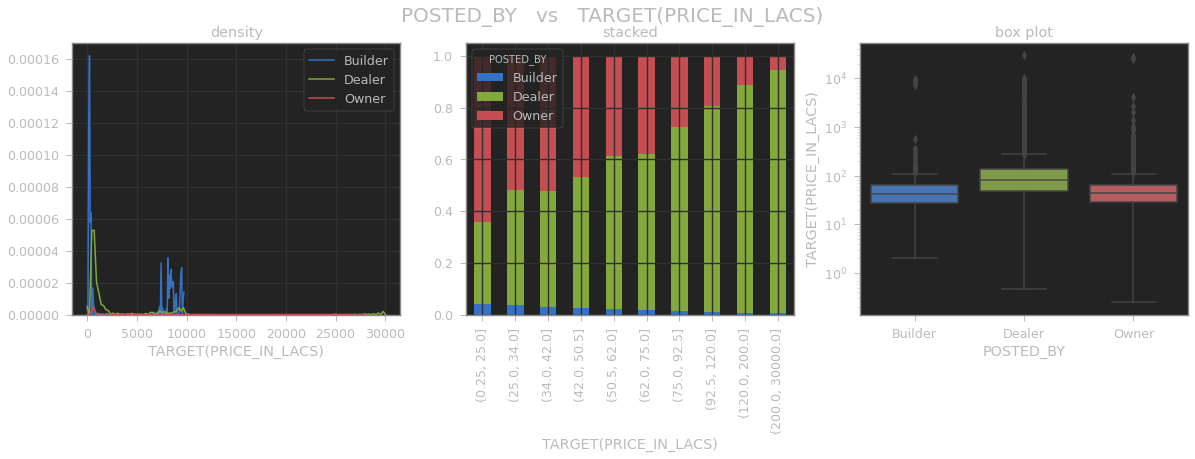

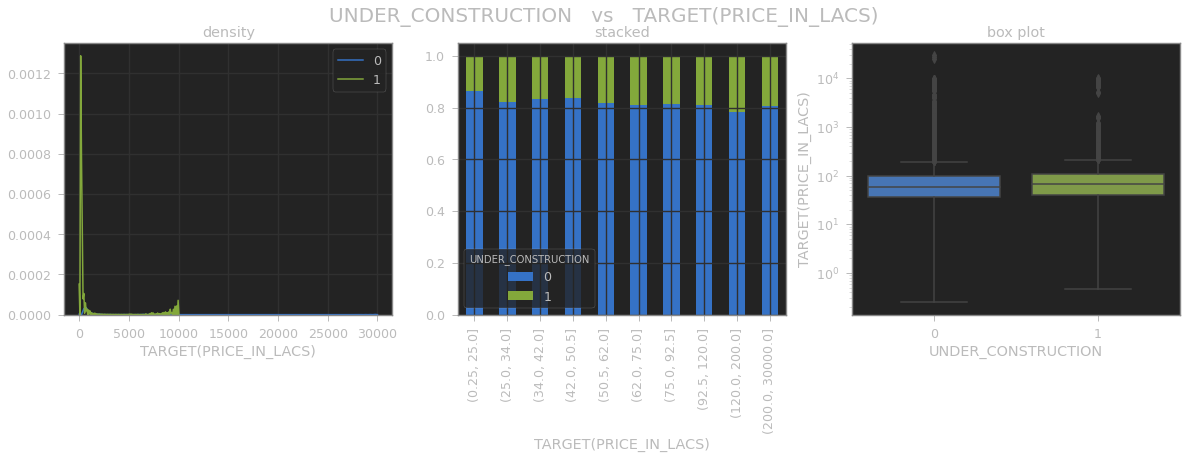

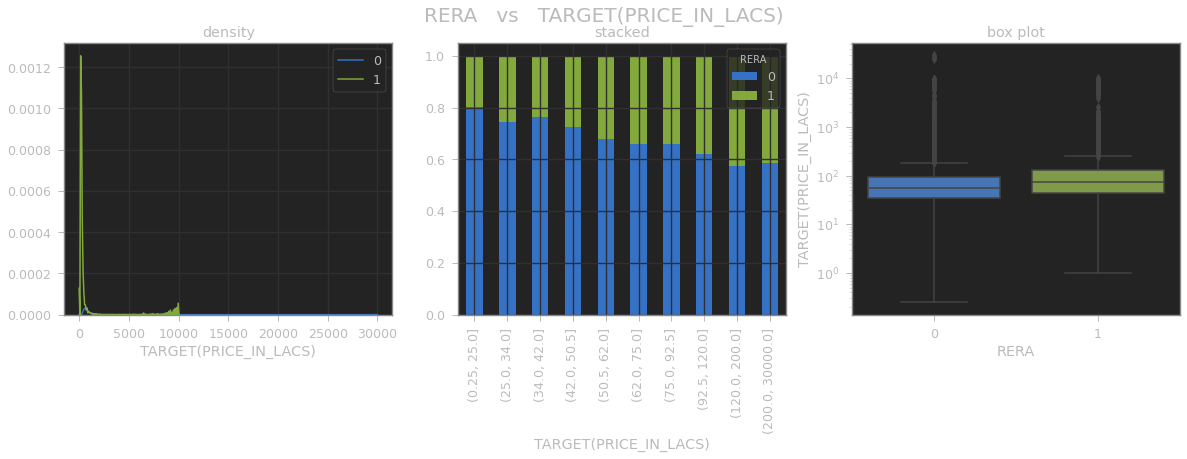

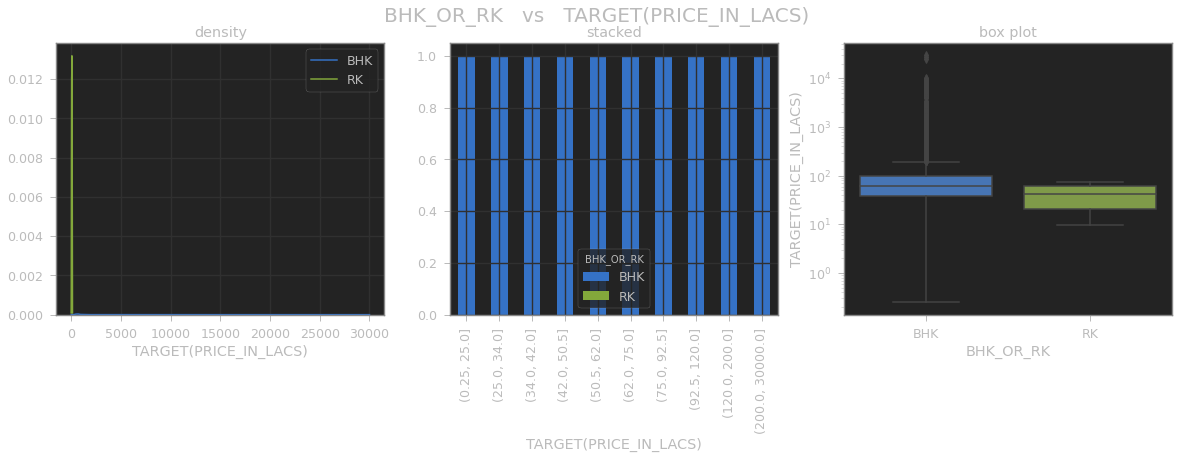

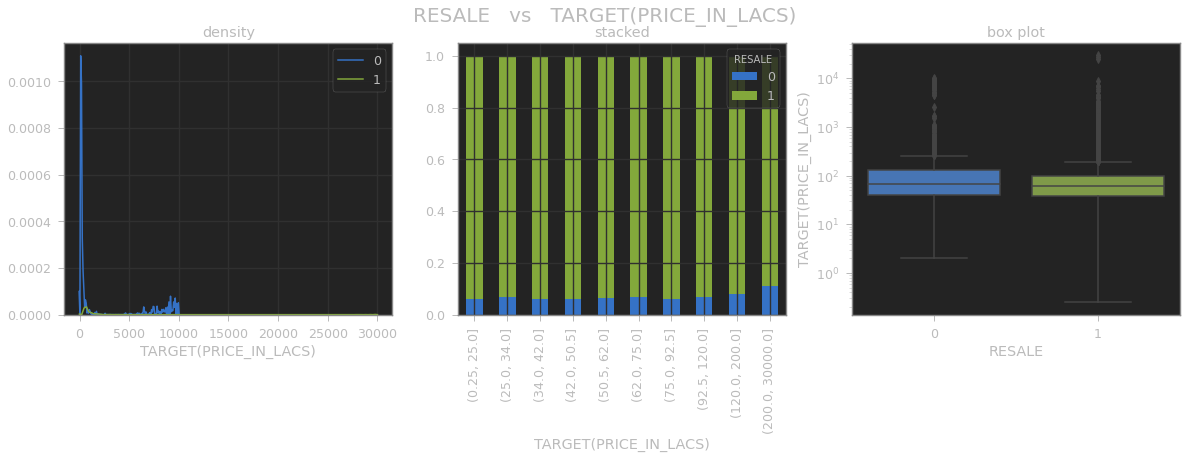

In [23]:
for cat_f in categorical_features:
    if cat_f in ['CITY', 'SUB_CITY']:
        continue
    show_density_stack_box_plot(df, cat_f, target, figsize=(20,5))

### EAD: numerical features

In [24]:
# summary of numerical features.
# I describe the summary of each numerical features.
# For BHK_NO and SQUARE_FT, those distribution are right skew.
# Their number of std of max value away from mean are 20 and 134 respectively. -> potential outlier
# Their number of std of min value away from mean are 1.58 and 0.01 respectively. -> not outlier
# 
# For LONGITUDE and LATITUDE, the number of std of max value away from mean are 6 and 7. -> potential outlier
# For LONGITUDE and LATITUDE, the number of std of min value away from mean are 9.5 and 18.8. -> potential outlier

# Note: RobustScaler or quantile transformation could be helpful to transform the heavy tail distribution 
# into normal distribution.
num_summary_df = df[numerical_features].describe()
display(num_summary_df)
print("how many std of max value away from mean:")
print((num_summary_df.loc["max"] - num_summary_df.loc["mean"])/num_summary_df.loc["std"])
print("how many std of min value away from mean:")
print(abs(num_summary_df.loc["min"] - num_summary_df.loc["mean"])/num_summary_df.loc["std"])

,BHK_NO,SQUARE_FT,LONGITUDE,LATITUDE
count,29451.000000,2.945100e+04,29451.000000,29451.000000
mean,2.392279,1.980217e+04,21.300255,76.837695
std,0.879091,1.901335e+06,6.205306,10.557747
min,1.000000,3.000000e+00,-37.713008,-121.761248
25%,2.000000,9.000211e+02,18.452663,73.798100
50%,2.000000,1.175057e+03,20.750000,77.324137
75%,3.000000,1.550688e+03,26.900926,77.828740
max,20.000000,2.545455e+08,59.912884,152.962676


how many std of max value away from mean:
BHK_NO        20.029457
SQUARE_FT    133.866817
LONGITUDE      6.222518
LATITUDE       7.210344
dtype: float64
how many std of min value away from mean:
BHK_NO        1.583770
SQUARE_FT     0.010413
LONGITUDE     9.510129
LATITUDE     18.810732
dtype: float64


array([[<AxesSubplot:title={'center':'BHK_NO'}>,
        <AxesSubplot:title={'center':'SQUARE_FT'}>],
       [<AxesSubplot:title={'center':'LONGITUDE'}>,
        <AxesSubplot:title={'center':'LATITUDE'}>]], dtype=object)

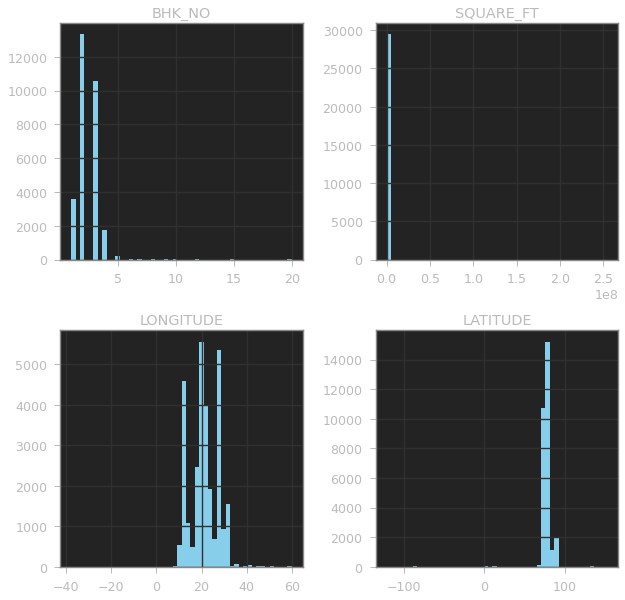

In [25]:
df[numerical_features].hist(bins=50,figsize=(10,10), color="skyblue")

In [26]:
# numerical feature: SQUARE_FT has highest correlation = 0.4 with target.
df[numerical_features + [target]].corr()[target]

BHK_NO                   0.112283
SQUARE_FT                0.402685
LONGITUDE               -0.031112
LATITUDE                -0.017254
TARGET(PRICE_IN_LACS)    1.000000
Name: TARGET(PRICE_IN_LACS), dtype: float64

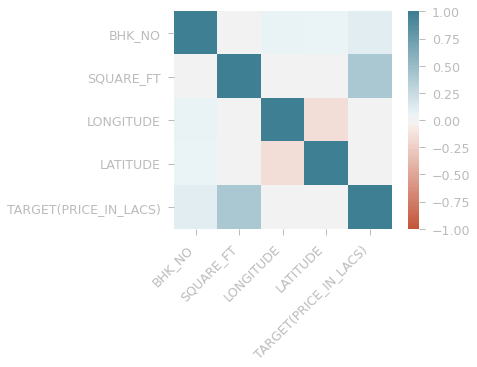

In [27]:
ax = sns.heatmap(
    df[numerical_features + [target]].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [ ]:
sns.pairplot(df[numerical_features + [target]], diag_kind='kde')

In [28]:
# Calculate the p-value between target and numerical feature.
# it shows that all the numerical features are significally robust with threshold p-value = 0.05
# Especially p-value of 'BHK_NO.' and 'SQUARE_FT' is much smaller than 0.05.
_, pval = f_regression(df[numerical_features], df[target])

# p-value
print("p-value: y vs numerical feature")
dict(zip(numerical_features, pval))

p-value: y vs numerical feature


{'BHK_NO': 3.0340080036817948e-83,
 'SQUARE_FT': 0.0,
 'LONGITUDE': 9.278763453914096e-08,
 'LATITUDE': 0.0030658852286176764}

### Analyze CITY feature

CITY is a categorical feature and has 256 unique cities. 
The goal is to find if a city is in an expensive area. It could be useful to predict price. Here we consider the following features vs CITY:
1. UNIT_PRICE_PER_SQ: avg unit price per square feet at each city.
2. BHK_NO: avg number of room at each city.
3. SQUARE_FT: avg square feet at each city.

In [29]:
# Analyze which CITY is expensive.
# Hajipur has highest unit price but it only has one data poin.
# it could be useful to derive embedding for CITY column.
# df[["CITY","UNIT_PRICE_PER_SQ"]].groupby("CITY").mean().sort_values("UNIT_PRICE_PER_SQ")
df[["CITY","UNIT_PRICE_PER_SQ"]].groupby("CITY").agg(["mean", "std", "count"])\
.sort_values(("UNIT_PRICE_PER_SQ",  "count")).reset_index()

CITY UNIT_PRICE_PER_SQ                
                                mean       std count
0         Agartala          0.055780       NaN     1
1        Midnapore          0.025640       NaN     1
2       Malappuram          0.042000       NaN     1
3    Machilipatnam          0.030560       NaN     1
4      Kurukshetra          0.070000       NaN     1
..             ...               ...       ...   ...
251          Noida          0.053539  0.022977  1767
252           Pune          0.068794  0.024428  1991
253         Mumbai          0.159192  0.106633  2023
254       Lalitpur          0.152868  0.110429  2993
255      Bangalore          0.064106  0.031626  4340

[256 rows x 4 columns]

In [30]:
df[["CITY","BHK_NO"]].groupby("CITY").agg(["mean", "std", "count"])\
.sort_values(("BHK_NO",  "count")).reset_index()

CITY    BHK_NO                
                        mean       std count
0         Agartala  2.000000       NaN     1
1        Midnapore  2.000000       NaN     1
2       Malappuram  1.000000       NaN     1
3    Machilipatnam  2.000000       NaN     1
4      Kurukshetra  2.000000       NaN     1
..             ...       ...       ...   ...
251          Noida  2.679683  0.774268  1767
252           Pune  2.171271  0.825047  1991
253         Mumbai  2.122590  0.858885  2023
254       Lalitpur  2.109255  0.902180  2993
255      Bangalore  2.578802  0.821756  4340

[256 rows x 4 columns]

In [31]:
df[["CITY","SQUARE_FT"]].groupby("CITY").agg(["mean", "std", "count"])\
.sort_values(("SQUARE_FT",  "count")).reset_index()

CITY      SQUARE_FT                    
                             mean           std count
0         Agartala     950.161348           NaN     1
1        Midnapore     780.031201           NaN     1
2       Malappuram     573.809524           NaN     1
3    Machilipatnam     719.895288           NaN     1
4      Kurukshetra     400.000000           NaN     1
..             ...            ...           ...   ...
251          Noida    2337.568562  1.069264e+04  1767
252           Pune    1641.121996  5.882493e+03  1991
253         Mumbai    1557.416224  5.243444e+03  2023
254       Lalitpur    1652.740217  7.383545e+03  2993
255      Bangalore  122511.993450  4.951679e+06  4340

[256 rows x 4 columns]

## Modeling

### Train/test split

In order to has similar target distribution among train and test set, we take a log transformation on target and bin it. Based on target_log_bin, we use stratified-split methods to obtain train
and test.

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

In [33]:
log_y_bin = f"{target}_log_bin"
split=StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=17)
for train_index,test_index in split.split(df, df[log_y_bin]):
    train=df.loc[train_index]
    test=df.loc[test_index]
print(f"train shape: {train.shape}")
print(f"train value counts on {log_y_bin}")
print(train[log_y_bin].value_counts())
print("-"*100)
print(f"test shape: {test.shape}")
print(f"test value counts on {log_y_bin}")
print(test[log_y_bin].value_counts())

train shape: (17670, 18)
train value counts on TARGET(PRICE_IN_LACS)_log_bin
1    4556
4    4384
2    4382
3    4348
Name: TARGET(PRICE_IN_LACS)_log_bin, dtype: int64
----------------------------------------------------------------------------------------------------
test shape: (11781, 18)
test value counts on TARGET(PRICE_IN_LACS)_log_bin
1    3038
4    2922
2    2922
3    2899
Name: TARGET(PRICE_IN_LACS)_log_bin, dtype: int64


### Create a model dictionary

In [147]:
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet,
                                ARDRegression, BayesianRidge, SGDRegressor,
                                HuberRegressor, RidgeCV, LassoCV, ElasticNetCV)
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor,
                               GradientBoostingRegressor)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, RobustScaler,
                                    PowerTransformer, QuantileTransformer)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error)
from copy import deepcopy
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPRegressor

sklearn_regression_model_dict = {
     "LinearRegression"              : LinearRegression,
     "Ridge"                         : Ridge,
     "Lasso"                         : Lasso,
     "ElasticNet"                    : ElasticNet,
     "RandomForestRegressor"         : RandomForestRegressor,
     "AdaBoostRegressor"             : AdaBoostRegressor,
     "ARDRegression"                 : ARDRegression,
     "XGBRegressor"                  : XGBRegressor,
     "LGBMRegressor"                 : LGBMRegressor,
     "SVR"                           : SVR,
     "GradientBoostingRegressor"     : GradientBoostingRegressor,
     "MLPRegressor"                  : MLPRegressor
 }

def get_metrics(y_true, y_pred):
    return {
        "rmse": [mean_squared_error(y_true, y_pred, squared=False)],
        "mae": [mean_absolute_error(y_true, y_pred)],
        "r2": [r2_score(y_true, y_pred)]
    }

### Baseline Model. Linear regression without feature engineer.

For base model, we only use subset of categorical features. And no further data transformation.

In [35]:
selected_numerical_features = ['BHK_NO', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']
# only use the following 5 categorical features.
selected_categorical_features = ['POSTED_BY',
                                 'UNDER_CONSTRUCTION',
                                 # 'READY_TO_MOVE', # same as 'UNDER_CONSTRUCTION'
                                 'RERA',
                                 'BHK_OR_RK',
                                 'RESALE',
                                 # 'SUB_CITY', # too many distinct classes
                                 # 'CITY' # too many distinct classes
                                ]

In [36]:
def data_transformer(train, test, 
                     selected_numerical_features,
                     selected_categorical_features, 
                     target):
    """
    Parameters
    -------------
    train: dataframe.
    test: dataframe.
    selected_numerical_features: list[str].
    selected_categorical_features: list[str].
    target: str.
    
    Returns
    -------------
    (X_train_transformed, X_test_transformed): tuple[dataframe].
    """
    data_transformer_num = Pipeline(
         steps=[('num_scaler', QuantileTransformer())])
    data_transformer_cat = Pipeline(
         steps=[('cat_one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
    preprocessor = ColumnTransformer(transformers=[
        ("num", data_transformer_num, selected_numerical_features),
        ("cat", data_transformer_cat, selected_categorical_features)
     ])
    X_train = train[selected_numerical_features + selected_categorical_features]
    y_train = train[target]
    X_test = test[selected_numerical_features + selected_categorical_features]
    y_test = test[target]
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    return (X_train_transformed, X_test_transformed, y_train, y_test, preprocessor)


In [37]:
def get_transformed_cat_feature(preprocessor, selected_categorical_features):
    transformed_cat_col = \
    preprocessor.transformers_[1][1].named_steps['cat_one_hot']\
    .get_feature_names(selected_categorical_features)
    transformed_cat_col = list(transformed_cat_col)
    return transformed_cat_col

def get_transformed_train_test_df(X_train_transformed, X_test_transformed,
                                  selected_numerical_features,
                                  transformed_cat_col):
    X_train_transformed_df = pd.DataFrame(X_train_transformed, 
                        columns=selected_numerical_features + transformed_cat_col)
    X_test_transformed_df = pd.DataFrame(X_test_transformed, 
                        columns=selected_numerical_features + transformed_cat_col)
    return (X_train_transformed_df, X_test_transformed_df)
    

#### transform train/test data using data transformer. 

In [38]:
(X_train_transformed, X_test_transformed, y_train, y_test, preprocessor) =\
data_transformer(train, 
                 test, 
                 selected_numerical_features,
                 selected_categorical_features, 
                 target)
transformed_cat_col = get_transformed_cat_feature(preprocessor, 
                                                  selected_categorical_features)

(X_train_transformed_df, X_test_transformed_df) = \
get_transformed_train_test_df(X_train_transformed, X_test_transformed,
                              selected_numerical_features,
                              transformed_cat_col)

In [39]:
X_train_transformed_df.head()

,BHK_NO,SQUARE_FT,LONGITUDE,LATITUDE,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,UNDER_CONSTRUCTION_0,UNDER_CONSTRUCTION_1,RERA_0,RERA_1,BHK_OR_RK_BHK,BHK_OR_RK_RK,RESALE_0,RESALE_1
0,0.000000,0.091460,0.685686,0.783784,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.751752,0.628153,0.199890,0.850851,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.751752,0.827828,0.492634,0.921895,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.346346,0.395635,0.163664,0.699700,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.346346,0.290261,0.992457,0.374658,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


<AxesSubplot:>

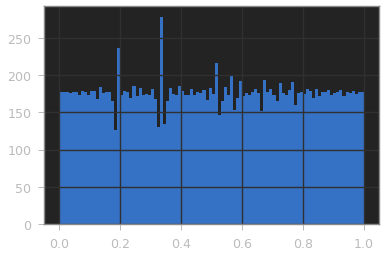

In [40]:
X_train_transformed_df["SQUARE_FT"].hist(bins=100)

In [41]:
X_test_transformed_df.head()

,BHK_NO,SQUARE_FT,LONGITUDE,LATITUDE,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,UNDER_CONSTRUCTION_0,UNDER_CONSTRUCTION_1,RERA_0,RERA_1,BHK_OR_RK_BHK,BHK_OR_RK_RK,RESALE_0,RESALE_1
0,0.000000,0.018898,0.013013,0.377377,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.346346,0.196166,0.462462,0.086086,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.751752,0.617799,0.658659,0.924374,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.000000,0.018418,0.495569,0.124560,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.751752,0.762507,0.059560,0.628128,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [42]:
base_model = sklearn_regression_model_dict["LinearRegression"]()
est = deepcopy(base_model)
base_model.fit(X=X_train_transformed_df, y=y_train)

LinearRegression()

In [43]:
# cv_metrics = [# "neg_mean_absolute_error",
#               "neg_root_mean_squared_error",
#               # "neg_median_absolute_error",
#               "r2",
#               # "neg_mean_absolute_percentage_error"
# ]
# cv_result = cross_validate(est, 
#                            X_train_transformed_df, 
#                            y_train,
#                            cv=5,
#                            scoring=cv_metrics,
#                            return_train_score=True)
# cv_result
# cv_result["train_r2"].mean(), cv_result["train_r2"].std()
# -cv_result["train_neg_root_mean_squared_error"].mean(), cv_result["test_neg_root_mean_squared_error"].std()

In [44]:
base_model_metrics = {"model_name": ["LinearRegression_v0"]}
train_metircs = get_metrics(y_train, base_model.predict(X_train_transformed_df))
base_model_metrics_train = {
    **base_model_metrics,
     **train_metircs,
    "data_type": ["train"]
}
test_metrics = get_metrics(y_test, base_model.predict(X_test_transformed_df))
base_model_metrics_test = {
    **base_model_metrics,
    **test_metrics,
    "data_type": ["test"]
}
base_metrics_summary_df = pd.concat([pd.DataFrame.from_dict(base_model_metrics_test),
                                    pd.DataFrame.from_dict(base_model_metrics_train)])
# print("train metrics:", train_metircs)
# print("test metrics:", test_metrics) 
display(base_metrics_summary_df)

,model_name,rmse,mae,r2,data_type
0,LinearRegression_v0,542.876999,189.193526,0.128670,test
0,LinearRegression_v0,662.115629,194.015846,0.111892,train


### Use training dataset to derive label embedding for categorical feature, CITY

For CITY feature, we create several embeddings. In each city, we calculate avg/std of
1. UNIT_PRICE_PER_SQ
2. BHK_NO
3. SQUARE_FT_PER_ROOM
4. SQUARE_FT

In [45]:
def create_embedding_for_cat(df, y, cat_f, methods=["mean", "std"]):
    """
    Parameters
    -------------
    df: dataframe.
    y: str.
    cat_f: str. categorical features.
    methods: list[str]. groupby methods.
    
    Returns
    -------------
    dfgby: dataframe.
    """
    dfgby = df[[cat_f, y]].groupby(cat_f).agg(methods).reset_index()
    dfgby.columns = [ "_".join(x) if x[1] != "" else x[0] for x in dfgby.columns]
    return dfgby.fillna(0.0)

In [46]:
city_embedding_from_unit_price = \
create_embedding_for_cat(train, y="UNIT_PRICE_PER_SQ", cat_f="CITY",
                         methods=["mean", "std", "median"])

In [47]:
city_embedding_from_BHK_NO = \
create_embedding_for_cat(train, y="BHK_NO", cat_f="CITY",
                         methods=["mean", "std", "median"])

In [48]:
city_embedding_from_SQUARE_FT_PER_ROOM = \
create_embedding_for_cat(train, y="SQUARE_FT_PER_ROOM", cat_f="CITY", 
                         methods=["mean", "std", "median"])

In [49]:
city_embedding_from_SQUARE_FT = \
create_embedding_for_cat(train, y="SQUARE_FT", cat_f="CITY", 
                         methods=["mean", "std", "median"])

In [50]:
city_embedding_from_unit_price.head()

,CITY,UNIT_PRICE_PER_SQ_mean,UNIT_PRICE_PER_SQ_std,UNIT_PRICE_PER_SQ_median
0,Agra,0.034852,0.036729,0.029145
1,Ahmednagar,0.033062,0.006076,0.033500
2,Ajmer,0.029024,0.009284,0.027900
3,Akola,0.038217,0.005307,0.039115
4,Aligarh,0.068529,0.133082,0.030760


In [51]:
city_embedding_from_BHK_NO.head()

,CITY,BHK_NO_mean,BHK_NO_std,BHK_NO_median
0,Agra,2.480000,0.646498,2.0
1,Ahmednagar,1.428571,0.646206,1.0
2,Ajmer,2.470588,0.799816,3.0
3,Akola,1.666667,1.032796,1.0
4,Aligarh,3.153846,0.898717,3.0


In [52]:
city_embedding_from_SQUARE_FT_PER_ROOM.head()

,CITY,SQUARE_FT_PER_ROOM_mean,SQUARE_FT_PER_ROOM_std,SQUARE_FT_PER_ROOM_median
0,Agra,711.732161,961.612791,542.459882
1,Ahmednagar,564.190638,133.577418,551.005803
2,Ajmer,490.684641,131.562412,483.870968
3,Akola,531.353553,123.210696,555.080843
4,Aligarh,423.411904,128.544126,440.605330


In [53]:
city_embedding_from_SQUARE_FT.head()

,CITY,SQUARE_FT_mean,SQUARE_FT_std,SQUARE_FT_median
0,Agra,1791.443704,2586.200734,1250.000000
1,Ahmednagar,752.645924,234.109354,714.765309
2,Ajmer,1185.790609,418.521608,1219.181794
3,Akola,786.939649,284.939644,655.600673
4,Aligarh,1347.334724,491.282834,1321.815990


In [54]:
# populate city_embedding into train dataset.
train_p = pd.merge(train, city_embedding_from_unit_price, on=["CITY"], how="left")
train_p = pd.merge(train_p, city_embedding_from_BHK_NO, on=["CITY"], how="left")
train_p = pd.merge(train_p, city_embedding_from_SQUARE_FT_PER_ROOM, 
                   on=["CITY"], how="left")
train_p = pd.merge(train_p, city_embedding_from_SQUARE_FT, 
                   on=["CITY"], how="left")
# populate city_embedding into test dataset.
test_p = pd.merge(test, city_embedding_from_unit_price, on=["CITY"], how="left")
test_p = pd.merge(test_p, city_embedding_from_BHK_NO, on=["CITY"], how="left")
test_p = pd.merge(test_p, city_embedding_from_SQUARE_FT_PER_ROOM, on=["CITY"], how="left")
test_p = pd.merge(test_p, city_embedding_from_SQUARE_FT, on=["CITY"], how="left")

In [55]:
train_p.head()


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,...,UNIT_PRICE_PER_SQ_median,BHK_NO_mean,BHK_NO_std,BHK_NO_median,SQUARE_FT_PER_ROOM_mean,SQUARE_FT_PER_ROOM_std,SQUARE_FT_PER_ROOM_median,SQUARE_FT_mean,SQUARE_FT_std,SQUARE_FT_median
0,Dealer,1,0,1,BHK,626.005054,0,1,"Ghodbunder Road,Lalitpur",24.690280,...,0.128555,2.115299,0.904790,2.0,843.172535,4.112217e+03,525.366129,1710.365527,8.556774e+03,1015.054393
1,Dealer,0,0,3,BHK,1336.073998,1,1,"Korattur,Chennai",13.114624,...,0.050630,2.258367,0.878043,2.0,2889.698059,5.259852e+04,470.537215,8066.586852,1.576748e+05,967.246674
2,Dealer,0,1,3,BHK,1750.000000,1,1,"Palasuni,Bhubaneswar",20.304302,...,0.041000,2.520000,0.672768,2.0,563.141522,1.039519e+02,562.951496,1397.392202,3.666665e+02,1314.885820
3,Owner,0,0,2,BHK,1067.022341,1,1,"Horamavu Agara,Bangalore",13.031800,...,0.057690,2.578010,0.764742,3.0,73410.049210,2.219337e+06,560.039532,204375.545108,6.417732e+06,1330.120482
4,Owner,0,0,2,BHK,950.168919,1,1,"Dalhousie Cantonment,Dalhousie",32.537765,...,0.046640,2.000000,0.000000,2.0,427.546585,6.722871e+01,427.546585,855.093170,1.344574e+02,855.093170


In [56]:
# Use median value in train dataset for nan value in test dataset.
embedding_cols = ["UNIT_PRICE_PER_SQ_mean", "UNIT_PRICE_PER_SQ_std", 
                  "UNIT_PRICE_PER_SQ_median",
                  "BHK_NO_mean", "BHK_NO_std", "BHK_NO_median", 
                  "SQUARE_FT_PER_ROOM_mean", "SQUARE_FT_PER_ROOM_std", 
                  "SQUARE_FT_PER_ROOM_median",
                  "SQUARE_FT_mean", "SQUARE_FT_std", "SQUARE_FT_median"
                 ]
embedding_cols_median_value = train_p[embedding_cols].median().to_dict()
embedding_cols_median_value

for t in embedding_cols:
    default_val = embedding_cols_median_value[t]
    test_p[t].fillna(default_val, inplace=True)

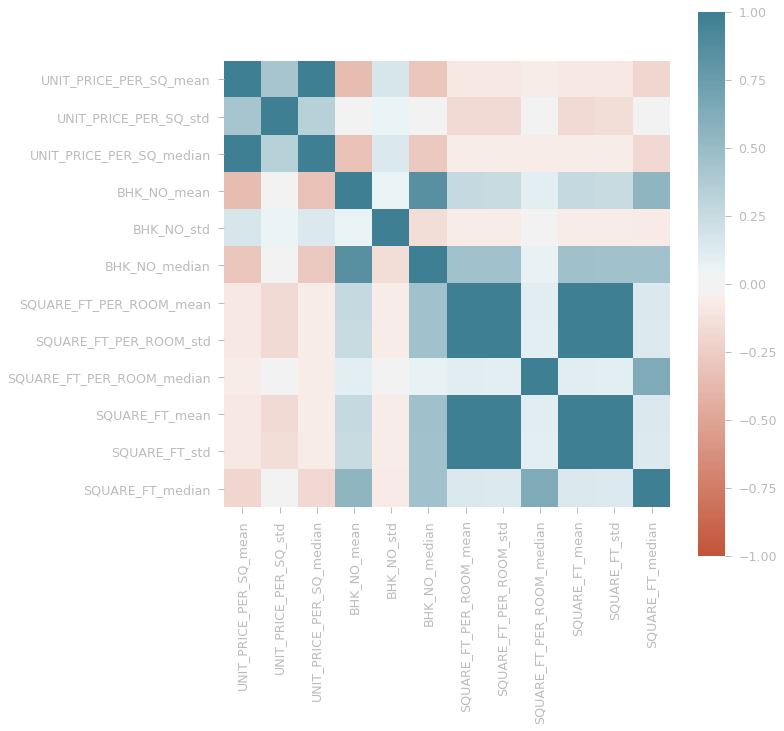

In [57]:
# train_p[embedding_cols].corr()
_, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(
    train_p[embedding_cols].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,# figsize=(10, 10)
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);

Use VIF to drop highly correlation features

In [58]:
from copy import deepcopy
interested_features = numerical_features + embedding_cols
dfx = deepcopy(train_p[interested_features])
drop_threshold = 10
drop = True
to_drop_list = []
while drop:
    drop = False
    current_features = dfx.columns
    vif = [variance_inflation_factor(dfx[current_features].values, 
            dfx.columns.get_loc(f)) for f in dfx.columns]
    max_vif = max(vif)
    max_vif_index = vif.index(max_vif)
    to_drop_f = dfx.columns[max_vif_index]
    if max_vif > drop_threshold:
        print(f'Drop {dfx.columns[max_vif_index]} with vif={max_vif}')
        drop = True
        dfx.drop(to_drop_f, inplace=True, axis=1)
        to_drop_list += [to_drop_f]
    if dfx.shape[0] ==1:
        drop = False

Drop SQUARE_FT_PER_ROOM_std with vif=682393.0419657252
Drop SQUARE_FT_PER_ROOM_mean with vif=21664.04397528654
Drop SQUARE_FT_mean with vif=696.1800795260208
Drop BHK_NO_mean with vif=316.27068719124105
Drop UNIT_PRICE_PER_SQ_mean with vif=174.50331064653503
Drop BHK_NO_median with vif=51.72675720738564
Drop SQUARE_FT_PER_ROOM_median with vif=35.0272435438602
Drop LATITUDE with vif=23.765272766253435
Drop LONGITUDE with vif=12.405526911213963


In [59]:
to_drop_list

['SQUARE_FT_PER_ROOM_std',
 'SQUARE_FT_PER_ROOM_mean',
 'SQUARE_FT_mean',
 'BHK_NO_mean',
 'UNIT_PRICE_PER_SQ_mean',
 'BHK_NO_median',
 'SQUARE_FT_PER_ROOM_median',
 'LATITUDE',
 'LONGITUDE']

Those CITY related embedding features are highly correlated to each. Thus, we dont use all of them.

In [60]:

# selected_numerical_features = ['BHK_NO', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE',
#                                'UNIT_PRICE_PER_SQ_mean', 'UNIT_PRICE_PER_SQ_std',
#                                'BHK_NO_mean', 'BHK_NO_std', 
#                                'SQUARE_FT_PER_ROOM_mean', 'SQUARE_FT_PER_ROOM_std',
#                               ]
selected_numerical_features = list(set(interested_features) - set(to_drop_list))
print(selected_numerical_features)
selected_categorical_features = ['POSTED_BY',
                                 'UNDER_CONSTRUCTION',
                                 # 'READY_TO_MOVE', # same as 'UNDER_CONSTRUCTION'
                                 'RERA',
                                 'BHK_OR_RK',
                                 'RESALE',
                                 # 'SUB_CITY', # too many distinct classes
                                 # 'CITY' # too many distinct classes
                                ]

['UNIT_PRICE_PER_SQ_median', 'SQUARE_FT_median', 'BHK_NO', 'SQUARE_FT_std', 'SQUARE_FT', 'BHK_NO_std', 'UNIT_PRICE_PER_SQ_std']


In [61]:
(X_train_transformed, X_test_transformed, y_train, y_test, preprocessor) =\
data_transformer(train_p, 
                 test_p, 
                 selected_numerical_features,
                 selected_categorical_features, 
                 target)
transformed_cat_col = get_transformed_cat_feature(preprocessor, 
                                                  selected_categorical_features)

(X_train_transformed_df, X_test_transformed_df) = \
get_transformed_train_test_df(X_train_transformed, X_test_transformed,
                              selected_numerical_features,
                              transformed_cat_col)

In [62]:
sklearn_regression_model_dict.keys()

dict_keys(['LinearRegression', 'Ridge', 'RidgeCV', 'Lasso', 'LassoCV', 'ElasticNet', 'ElasticNetCV', 'RandomForestRegressor', 'AdaBoostRegressor', 'ARDRegression', 'XGBRegressor', 'LGBMRegressor', 'SVR', 'GradientBoostingRegressor'])

In [63]:
X_train_transformed_df

,UNIT_PRICE_PER_SQ_median,SQUARE_FT_median,BHK_NO,SQUARE_FT_std,SQUARE_FT,BHK_NO_std,UNIT_PRICE_PER_SQ_std,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,UNDER_CONSTRUCTION_0,UNDER_CONSTRUCTION_1,RERA_0,RERA_1,BHK_OR_RK_BHK,BHK_OR_RK_RK,RESALE_0,RESALE_1
0,0.826326,0.152152,0.000000,0.611111,0.091460,0.849349,0.919419,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.459960,0.053554,0.751752,0.832332,0.628153,0.757257,0.348849,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.335335,0.676176,0.751752,0.061061,0.827828,0.105105,0.175676,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.547047,0.701201,0.346346,0.868368,0.395635,0.356356,0.554054,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.427840,0.024250,0.346346,0.005050,0.290261,0.000000,0.003943,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17665,0.459960,0.053554,0.000000,0.832332,0.041366,0.757257,0.348849,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
17666,0.826326,0.152152,0.000000,0.611111,0.026543,0.849349,0.919419,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
17667,0.083584,0.415916,0.346346,0.155656,0.649596,0.905405,0.098599,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
17668,0.031532,0.406907,0.346346,0.088589,0.142208,0.307307,0.148148,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [64]:
X_test_transformed_df.describe()

,UNIT_PRICE_PER_SQ_median,SQUARE_FT_median,BHK_NO,SQUARE_FT_std,SQUARE_FT,BHK_NO_std,UNIT_PRICE_PER_SQ_std,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,UNDER_CONSTRUCTION_0,UNDER_CONSTRUCTION_1,RERA_0,RERA_1,BHK_OR_RK_BHK,BHK_OR_RK_RK,RESALE_0,RESALE_1
count,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000
mean,0.491764,0.488392,0.490093,0.490959,0.497188,0.484552,0.501546,0.020287,0.616331,0.363382,0.820134,0.179866,0.685001,0.314999,0.999066,0.000934,0.071047,0.928953
std,0.282574,0.285054,0.280109,0.275694,0.287861,0.285690,0.287899,0.140986,0.486299,0.480994,0.384092,0.384092,0.464535,0.464535,0.030544,0.030544,0.256914,0.256914
min,0.000004,0.001001,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.255756,0.279780,0.346346,0.247247,0.245621,0.266767,0.246246,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,0.510511,0.507007,0.346346,0.478478,0.495304,0.501502,0.554054,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.726226,0.701201,0.751752,0.761762,0.745397,0.749925,0.780781,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,0.964965,0.999163,1.000000,0.868368,0.999000,1.000000,0.999165,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Run experiments on several models

In [65]:
def run_experiment(models_config, 
                   sklearn_regression_model_dict, 
                   X_train_transformed_df,
                   y_train,
                   X_test_transformed_df,
                   y_test):
    metrics_df = []
    model_dict = {}
    for model in models_config:
        print(model)
        model_obj = sklearn_regression_model_dict[model]()
        model_obj.fit(X_train_transformed_df, y_train)
        model_dict[model] = model_obj
        y_test_pred = model_obj.predict(X_test_transformed_df)
        test_metrics = get_metrics(y_test, y_test_pred)
        test_metrics["data_type"] = ["test"]
        y_train_pred = model_obj.predict(X_train_transformed_df)
        train_metrics = get_metrics(y_train, y_train_pred)
        train_metrics["data_type"] = ["train"]
        # metrics["model_name"] = [model]
        test_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **test_metrics})
        train_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **train_metrics})
        metrics_df += [pd.concat([train_metrics_df, test_metrics_df])]
        del model_obj, test_metrics, train_metrics
    metrics_df = pd.concat(metrics_df)
    return metrics_df, model_dict

In [66]:
models_config = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 
                 'RandomForestRegressor', 'SVR', 'XGBRegressor', 
                 'GradientBoostingRegressor', 'AdaBoostRegressor']
metrics_df, model_dict = run_experiment(models_config, 
                   sklearn_regression_model_dict, 
                   X_train_transformed_df,
                   y_train,
                   X_test_transformed_df,
                   y_test)

LinearRegression
Ridge
Lasso
ElasticNet
RandomForestRegressor
SVR
XGBRegressor
GradientBoostingRegressor
AdaBoostRegressor


In [68]:
metrics_df = pd.concat([base_metrics_summary_df, metrics_df])
metrics_df.sort_values(["model_name", "data_type"])

,model_name,rmse,mae,r2,data_type
0,AdaBoostRegressor,196.408962,108.302585,0.885948,test
0,AdaBoostRegressor,175.622687,106.734500,0.937517,train
0,ElasticNet,567.750253,124.487020,0.046996,test
0,ElasticNet,690.654822,130.460657,0.033682,train
0,GradientBoostingRegressor,149.848146,41.002725,0.933613,test
0,GradientBoostingRegressor,104.732326,37.623427,0.977779,train
0,Lasso,536.619911,180.534832,0.148640,test
0,Lasso,658.033092,184.944672,0.122810,train
0,LinearRegression,537.318833,187.956907,0.146420,test
0,LinearRegression,657.735539,191.973711,0.123603,train


Best Model: GradientBoostingRegressor

In [69]:
mask = (metrics_df.data_type == "test")
metrics_df_best = metrics_df[mask]
best_model_name = metrics_df_best[metrics_df_best.rmse 
                                  == min(metrics_df_best.rmse)]["model_name"].values[0]
metrics_df_best = metrics_df[metrics_df.model_name == best_model_name]
metrics_df_best

,model_name,rmse,mae,r2,data_type
0,GradientBoostingRegressor,104.732326,37.623427,0.977779,train
0,GradientBoostingRegressor,149.848146,41.002725,0.933613,test


### Feature Importance.

The best model is GradientBoostingRegressor. Here is feature importance.
Those important ones are SQUARE_FT, RESALE, UNIT_PRICE_PER_SQ_median.
It also make senses that the larger size of house, the more expensive it will be.

In [87]:
# numerical_features + categorical_features
def derive_raw_features(x):
    for f in categorical_features:
        if f in x:
            return f
    return x

,score
raw_feature,
BHK_NO,0.006927
BHK_NO_std,0.000178
BHK_OR_RK,0.000000
POSTED_BY,0.001152
RERA,0.000332
RESALE,0.078314
SQUARE_FT,0.884078
SQUARE_FT_median,0.001098
SQUARE_FT_std,0.000379


<AxesSubplot:xlabel='raw_feature'>

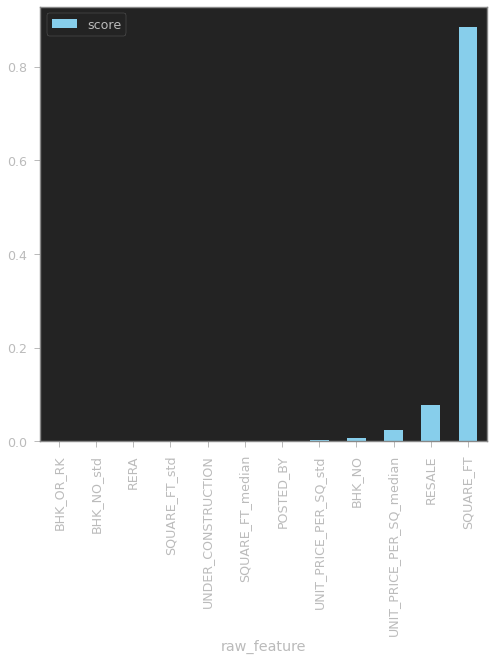

In [95]:
feature_names = X_train_transformed_df.columns.tolist()
f_importances = model_dict[best_model_name].feature_importances_
# forest_importances = pd.DataFrame(data=f_importances, index=feature_names, columns=["score"])
df_importances = pd.DataFrame(data=zip(feature_names, f_importances), 
                                  columns=["features","score"]).sort_values("score")
df_importances["raw_feature"] = df_importances["features"].apply(lambda x: derive_raw_features(x))
feature_summary = df_importances[["raw_feature", "score"]].groupby("raw_feature").sum()
# forest_importances.set_index("features").plot.bar(figsize=(8, 8))
display(feature_summary)
feature_summary.sort_values("score").plot.bar(figsize=(8, 8), color="skyblue")

In [72]:
## try target transformation. the test metrics is not as good as before.
target_transformation = False
if target_transformation:
    metrics_df = []
    for model in models_config:
        print(model)
        model_obj_0 = sklearn_regression_model_dict[model]()
        model_obj = TransformedTargetRegressor(regressor=model_obj_0,
                                            func=np.log, inverse_func=np.exp)
        model_obj.fit(X_train_transformed_df, y_train)
        y_test_pred = model_obj.predict(X_test_transformed_df)
        test_metrics = get_metrics(y_test, y_test_pred)
        test_metrics["data_type"] = ["test"]
        y_train_pred = model_obj.predict(X_train_transformed_df)
        train_metrics = get_metrics(y_train, y_train_pred)
        train_metrics["data_type"] = ["train"]
        # metrics["model_name"] = [model]
        test_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **test_metrics})
        train_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **train_metrics})
        metrics_df += [pd.concat([train_metrics_df, test_metrics_df])]
        del model_obj, test_metrics, train_metrics
    metrics_df = pd.concat(metrics_df)

### GridSearch

In [149]:
RandomForestRegressor_config = {
    "n_estimators": [100, 200, 500, 800],
    "max_depth": [5, 10, 15],
    "max_features" : ["auto", "sqrt", "log2", None],
    "max_leaf_nodes" : [None, 10, 20],
    "max_samples" : [None],
    "min_impurity_decrease": [0.0],
    "min_impurity_split": [None],
    "min_samples_leaf": [1, 3, 5],
    "min_samples_split": [2, 5, 10],
    "min_weight_fraction_leaf": [0.0],
    "bootstrap": [True, False],
    "random_state": [17]
}

XGBRegressor_config = {
     "n_estimators"       : [100, 500],
     "booster"            : ["gbtree", "gblinear", "dart"],
     # "tree_method"        : ["auto", "exact", "approx", "hist"],
     "max_depth"          : [5, 15],
     # "eta"                : [0.1, 0.8],
     # "gamma"              : [0.1, 10.0],
     "min_child_weight"   : [1, 5, 10],
     # "colsample_bytree"   : [0.5, 0.8],
     "learning_rate"      : [0.01],
     "subsample"          : [0.7, 1]
}

GradientBoostingRegressor_config = {
    'n_estimators':[200, 500],
    'learning_rate':[0.01],
    'max_depth':[6, 8],
    'subsample':[.5, .75],
    'random_state':[1],
    'max_features': ['sqrt'],
    'max_leaf_nodes': [None, 3, 5],
    'alpha': [0.5, 0.9],
    'min_samples_leaf': [1, 5]
}

MLPRegressor_config = {
     "hidden_layer_sizes" : [(50, 5), (100, 10)],
     # "activation"         : ["identity", "logistic", "tanh", "relu"],
    "activation"         : ["relu"],
     "solver": ["adam"],
     "max_iter": [600],
     "early_stopping": [True],
     "validation_fraction": [0.1],
     "beta_1": [0.1, 0.5],
     "beta_2": [0.1, 0.5],
     "epsilon": [1e-6, 1e-8],
     # "n_iter_no_change": [10, 20]
 }

grid_search_config = {
    "RandomForestRegressor" : RandomForestRegressor_config,
    "XGBRegressor": XGBRegressor_config,
    "GradientBoostingRegressor": GradientBoostingRegressor_config,
 "MLPRegressor":    MLPRegressor_config
}

In [ ]:
def run_grid_search_experiment(grid_search_config,
                               sklearn_regression_model_dict,
                               model,
                               X_train_transformed_df,
                               y_train,
                               X_test_transformed_df,
                               y_test):
    # model = "GradientBoostingRegressor"
    gs_param = grid_search_config.get(model)
    gs_model = GridSearchCV(sklearn_regression_model_dict[model](),
                            gs_param, 
                            neg_root_mean_squared_error

In [138]:
def run_grid_search_experiment(grid_search_config,
                               sklearn_regression_model_dict,
                               model,
                               X_train_transformed_df,
                               y_train,
                               X_test_transformed_df,
                               y_test):
    # model = "GradientBoostingRegressor"
    gs_param = grid_search_config.get(model)
    gs_model = GridSearchCV(sklearn_regression_model_dict[model](),
                            gs_param, 
                            verbose=2,
                            n_jobs=-1,
                            cv=5)
    gs_model.fit(X_train_transformed_df, y_train)
    best_est = gs_model.best_estimator_
    y_test_pred = best_est.predict(X_test_transformed_df)
    test_metrics = get_metrics(y_test, y_test_pred)
    test_metrics["data_type"] = ["test"]
    y_train_pred = best_est.predict(X_train_transformed_df)
    train_metrics = get_metrics(y_train, y_train_pred)
    train_metrics["data_type"] = ["train"]
    test_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **test_metrics})
    train_metrics_df = pd.DataFrame.from_dict({"model_name": model,
                                                   **train_metrics})
    metrics_df = pd.concat([train_metrics_df, test_metrics_df])
    print(f"Best fit param: {gs_model.best_params_}")
    return metrics_df, gs_model, best_est

In [139]:
model = "GradientBoostingRegressor"
df_gb, gs_model_gb, best_est_gb = run_grid_search_experiment(grid_search_config,
                                   sklearn_regression_model_dict,
                                   model,
                                   X_train_transformed_df,
                                   y_train,
                                   X_test_transformed_df,
                                   y_test)
display(df_gb)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best fit param: {'alpha': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_state': 1, 'subsample': 0.75}


,model_name,rmse,mae,r2,data_type
0,GradientBoostingRegressor,99.142879,36.851070,0.980088,train
0,GradientBoostingRegressor,146.541086,40.900515,0.936511,test


In [144]:
model = "XGBRegressor"
df_xgb, gs_model_xgb, best_est_xgb = run_grid_search_experiment(grid_search_config,
                                   sklearn_regression_model_dict,
                                   model,
                                   X_train_transformed_df,
                                   y_train,
                                   X_test_transformed_df,
                                   y_test)
display(df_xgb)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

### Neural Network [sklearn]

In [150]:
# gridCV = GridSearchCV(estimator=mlpr, param_grid=param_list)
model = "MLPRegressor"
df_nn, gs_model_nn, best_est_nn = run_grid_search_experiment(grid_search_config,
                                   sklearn_regression_model_dict,
                                   model,
                                   X_train_transformed_df,
                                   y_train,
                                   X_test_transformed_df,
                                   y_test)
display(df_nn)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best fit param: {'activation': 'relu', 'beta_1': 0.1, 'beta_2': 0.5, 'early_stopping': True, 'epsilon': 1e-06, 'hidden_layer_sizes': (100, 10), 'max_iter': 600, 'solver': 'adam', 'validation_fraction': 0.1}


,model_name,rmse,mae,r2,data_type
0,MLPRegressor,491.159323,78.395582,0.511299,train
0,MLPRegressor,357.706152,76.041338,0.621703,test


In [128]:
# model = "GradientBoostingRegressor"
# gs_param = grid_search_config.get(model)
# gs_model = GridSearchCV(sklearn_regression_model_dict[model](),
#                         gs_param, 
#                         verbose=2,
#                         n_jobs=-1,
#                         cv=5)
# gs_model.fit(X_train_transformed_df, y_train)
# best_est = gs_model.best_estimator_
# y_test_pred = best_est.predict(X_test_transformed_df)
# test_metrics = get_metrics(y_test, y_test_pred)
# test_metrics["data_type"] = ["test"]
# y_train_pred = best_est.predict(X_train_transformed_df)
# train_metrics = get_metrics(y_train, y_train_pred)
# train_metrics["data_type"] = ["train"]

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [130]:
gs_model.best_params_

{'alpha': 0.5,
 'learning_rate': 0.01,
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'n_estimators': 500,
 'random_state': 1,
 'subsample': 0.75}

In [131]:
test_metrics

{'rmse': [146.5410857448875],
 'mae': [40.90051484772235],
 'r2': [0.9365109732522648],
 'data_type': ['test']}